In [1]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# import pandas
import pandas as pd

# import matplotlib
import matplotlib.pyplot as plt

# import prophet
from fbprophet import Prophet

In [2]:
# load data
wmt = pd.read_csv('https://raw.githubusercontent.com/gumdropsteve/intro_to_prophet/master/data/WMT.csv')

* Explore the dataset

In [3]:
wmt.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1972-08-25,0.063477,0.064697,0.063477,0.064453,0.023768,2508800
1,1972-08-28,0.064453,0.064941,0.064209,0.064209,0.023678,972800
2,1972-08-29,0.063965,0.063965,0.063477,0.063477,0.023408,1945600
3,1972-08-30,0.063477,0.063477,0.062988,0.063477,0.023408,409600
4,1972-08-31,0.062988,0.062988,0.062500,0.062500,0.023047,870400


* use only `Date` and `Adj Close` columns

In [4]:
df=wmt[['Date','Adj Close']]

In [5]:
df.head()

,Date,Adj Close
0,1972-08-25,0.023768
1,1972-08-28,0.023678
2,1972-08-29,0.023408
3,1972-08-30,0.023408
4,1972-08-31,0.023047


* rename columns to fit Prophet naming convention

In [6]:
df = df.rename(columns={'Date': 'ds',
                        'Adj Close': 'y'})

* convert date to datetime

In [7]:
df['ds'] = pd.DatetimeIndex(df['ds'])
df.dtypes

ds    datetime64[ns]
y            float64
dtype: object

* plot time-series

In [8]:
# set the column as the index
df.set_index('ds', inplace=True)

In [9]:
df.shape

(11815, 1)

<AxesSubplot:xlabel='ds'>

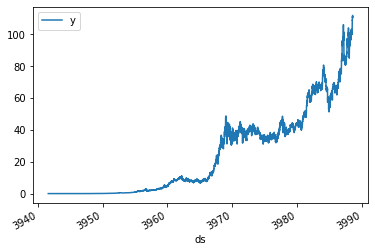

In [10]:
df.plot()

In [11]:
y=df['y'].resample('M').mean()

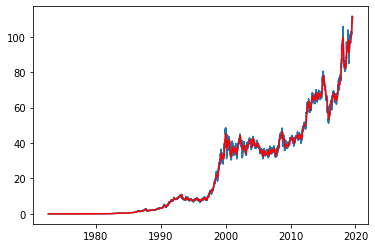

In [12]:
plt.plot(df['y'])
plt.plot(y, color='red')

In [13]:
df.shape

(11815, 1)

In [14]:
y.shape

(564,)

* instantiate Prophet

* fit model

In [15]:
# Python
m = Prophet()
m.fit(df.reset_index())

INFO:numexpr.utils:NumExpr defaulting to 6 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


* forecast 365 values in future 

In [16]:
# Python
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
12175,2020-06-27
12176,2020-06-28
12177,2020-06-29
12178,2020-06-30
12179,2020-07-01


* plot forecast

In [17]:
# Python
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
12175,2020-06-27,96.535009,91.941146,101.523388
12176,2020-06-28,96.537762,91.787798,101.424100
12177,2020-06-29,96.513977,91.497195,101.671923
12178,2020-06-30,96.534648,91.512223,101.217769
12179,2020-07-01,96.524340,91.352106,101.171242


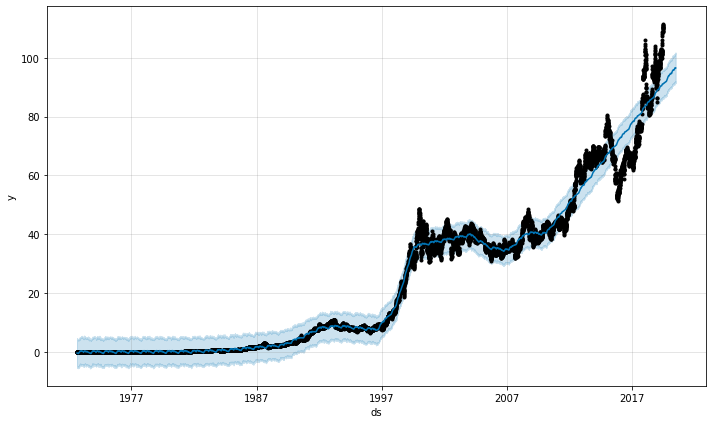

In [18]:
# Python
fig1 = m.plot(forecast)

* plot components

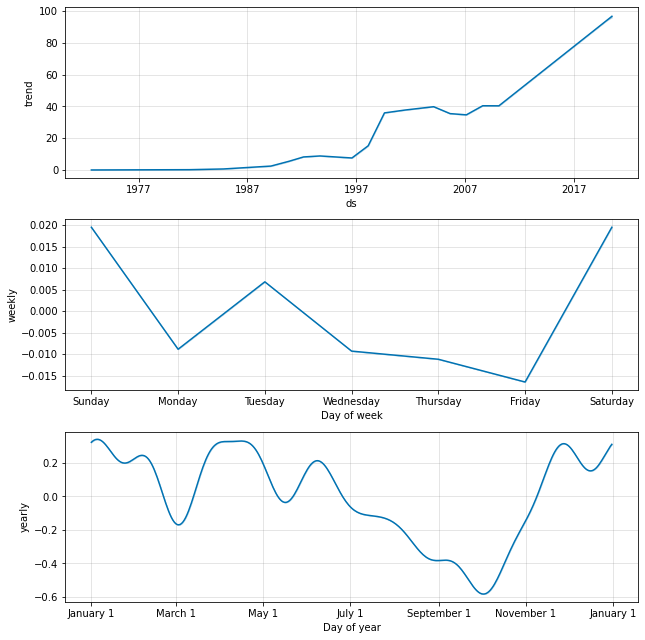

In [91]:
# Python
fig2 = m.plot_components(forecast)

- Compare the Prophet prediction vs Arima. Use the last 7 values we have in the timeseries as ground truth.

In [19]:
df

,y
ds,
1972-08-25,0.023768
1972-08-28,0.023678
1972-08-29,0.023408
1972-08-30,0.023408
1972-08-31,0.023047
...,...
2019-06-26,110.160004
2019-06-27,110.099998
2019-06-28,110.489998


In [20]:
y.shape

(564,)

In [21]:
y.head()

ds
1972-08-31    0.023462
1972-09-30    0.022363
1972-10-31    0.022180
1972-11-30    0.024380
1972-12-31    0.024592
Freq: M, Name: y, dtype: float64

<Figure size 1080x936 with 0 Axes>

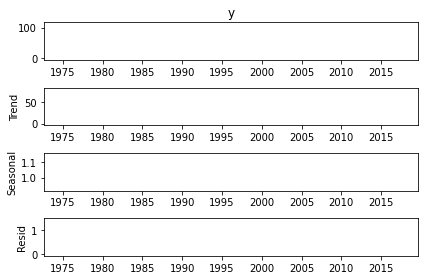

In [28]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
fig = plt.figure(figsize=(15,13))
result = seasonal_decompose(y, model='multiplicative',period=47)
result.plot();

In [29]:
from statsmodels.tsa.stattools import adfuller
def ADF_Stationarity_Test(timeseries,significance_level):
    '''prints adfuller test results
prints the conclusion stating whether timeseries is stationary based on the siginificance level (input parameter of function)'''
    X=pd.Series(timeseries).fillna(method='ffill')
    X=pd.Series(timeseries).fillna(method='bfill')
    result = adfuller(X)
    if result[1]<significance_level:
        explain=print("reject the null hypothesis: This dataset IS stationary, p value is",
                      result[1],". AD Fuller value is",result[0])
    else:
        explain=print("DO NOT reject the null hypothesis: This dataset IS NOT stationary, p value is",
                      result[1],". AD Fuller value is",result[0])
    return explain



In [30]:
ADF_Stationarity_Test(y,0.05)

DO NOT reject the null hypothesis: This dataset IS NOT stationary, p value is 1.0 . AD Fuller value is 2.8652942960578804


In [31]:
import numpy as np

In [32]:
y_trans=np.log(y)

In [33]:
ADF_Stationarity_Test(y_trans,0.05)

DO NOT reject the null hypothesis: This dataset IS NOT stationary, p value is 0.3772248447344675 . AD Fuller value is -1.8065294715334421


# Difference the original, NOT the log - *** ONE OR THE OTHER

# Apply differencing

In [109]:
new_df=pd.DataFrame(y)

In [112]:
new_df

,y,y_diff
ds,,
1972-08-31,0.023462,NaN
1972-09-30,0.022363,-0.001099
1972-10-31,0.022180,-0.000183
1972-11-30,0.024380,0.002200
1972-12-31,0.024592,0.000212
...,...,...
2019-03-31,97.532491,0.794404
2019-04-30,100.366358,2.833866
2019-05-31,101.212901,0.846543


In [111]:
new_df['y_diff']=new_df['y']-new_df['y'].shift(1)

In [107]:
#new_df['mine'] = new_df['y'].diff()

In [97]:
ADF_Stationarity_Test(new_df['y_diff'],0.05)

reject the null hypothesis: This dataset IS stationary, p value is 0.010775145354383217 . AD Fuller value is -3.4054301449581432


<AxesSubplot:xlabel='ds'>

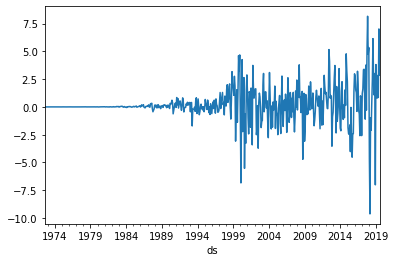

In [98]:
new_df['y_diff'].plot()

## Finding Optimal p,d,q using gridsearch

In [46]:
import itertools  

# Modelling off of the "differenced" series

In [112]:
#from the decomposition chart, anurag wanted to use 0-2 based on this (in his example)
#seasonal_pdq - Anurag used 12 - for months, if daily - use 30

In [47]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [48]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [50]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [51]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(new_df['y_diff'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2106.3526154366746
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2075.3662814214968
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2417.7452525623507
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2060.8310629168022
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2078.1300875469897
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2077.3645928249325
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2258.442800637994
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2069.2609021619905
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2056.3236656499676
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2025.9048709922813
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2343.1130695726943
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2014.0884519043252
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2031.7173983159719
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2027.8359746358376
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2192.324177894279
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2016.0884747545915
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2309.9237737202125
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2272.16536662

for test_df['y_diff']: ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:2013.0410039481685

## for test_df['y_diff']: ARIMA(1, 1, 2)x(2, 1, 3, 12)12 - AIC:1940.91360815833

Looks like ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:2011.007001543766 has lowest AIC - so go with those params

In [52]:
mod = sm.tsa.statespace.SARIMAX(new_df['y_diff'],
                                order=(1, 1, 2),
                                seasonal_order=(2, 1, 3, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4326      0.060     -7.199      0.000      -0.550      -0.315
ma.L1         -0.3201      0.054     -5.884      0.000      -0.427      -0.213
ma.L2         -0.6936      0.055    -12.572      0.000      -0.802      -0.586
ar.S.L12      -0.3483      0.253     -1.376      0.169      -0.844       0.148
ar.S.L24      -0.4141      0.297     -1.396      0.163      -0.995       0.167
ma.S.L12      -0.6624      0.250     -2.645      0.008      -1.153      -0.171
ma.S.L24      -0.0593      0.337     -0.176      0.860      -0.719       0.600
ma.S.L36      -0.2568      0.325     -0.790      0.430      -0.894       0.381
sigma2         2.3202      0.177     13.127      0.000       1.974       2.667


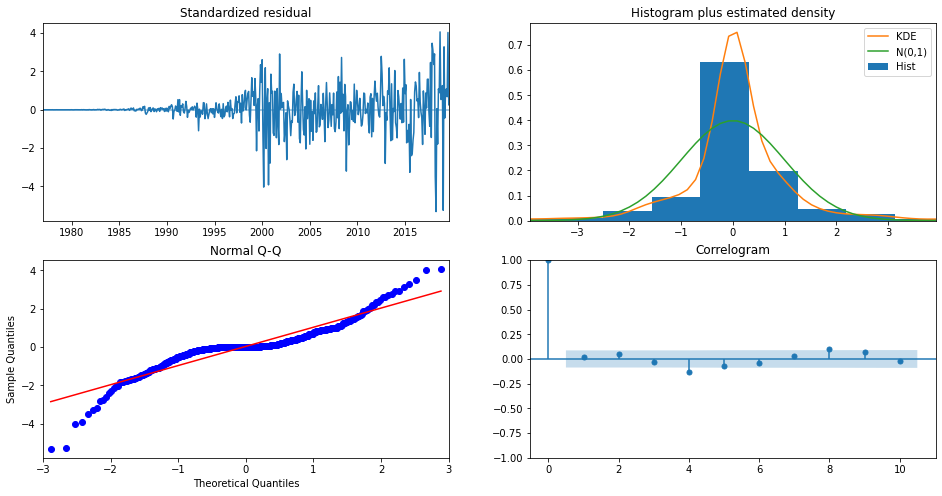

In [53]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [56]:
y.shape

(564,)

In [113]:
y[495:]

ds
2013-11-30     68.228733
2013-12-31     68.415178
2014-01-31     66.504226
2014-02-28     64.352952
2014-03-31     65.778574
                 ...    
2019-03-31     97.532491
2019-04-30    100.366358
2019-05-31    101.212901
2019-06-30    108.235000
2019-07-31    111.110000
Freq: M, Name: y, Length: 69, dtype: float64

In [74]:
#type(pred)

# Within this plot - I'm re-transforming the predictions into the original scale (before differencing)

In [132]:
new_df

,y,y_diff
ds,,
1972-08-31,0.023462,NaN
1972-09-30,0.022363,-0.001099
1972-10-31,0.022180,-0.000183
1972-11-30,0.024380,0.002200
1972-12-31,0.024592,0.000212
...,...,...
2019-03-31,97.532491,0.794404
2019-04-30,100.366358,2.833866
2019-05-31,101.212901,0.846543


In [135]:
pred_ci['lower y_diff'].shape

(67,)

In [136]:
new_df['y']['2014':].shift(1).shape

(67,)

In [123]:
#dir(pred)

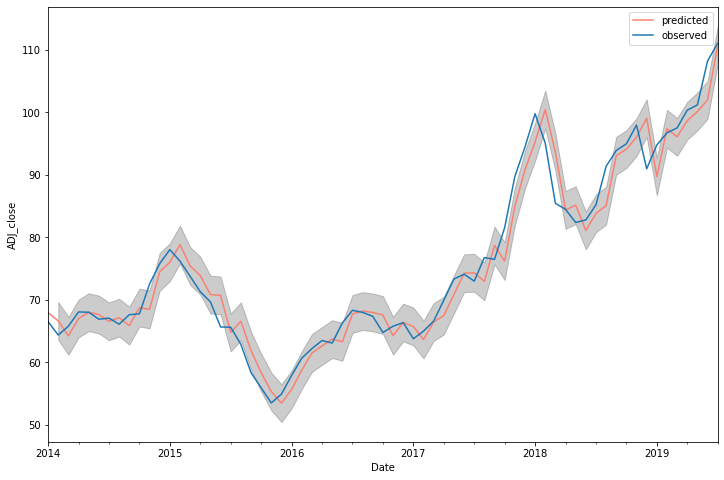

In [137]:
fig = plt.figure(figsize=(12,8))
pred = results.get_prediction(start=pd.to_datetime('2014-01-31'), dynamic=False)
pred_ci = pred.conf_int()

### Transform the predictions back to the same scale as before the differencing ###
pred_trans=pred.predicted_mean+new_df['y'].shift(1)
pred_low_trans=pred_ci['lower y_diff']+new_df['y']['2014':].shift(1)
pred_high_trans=pred_ci['upper y_diff']+new_df['y']['2014':].shift(1)

# pred_trans=pred.predicted_mean
# pred_low_trans=pred_ci['lower y_diff']
# pred_high_trans=pred_ci['upper y_diff']

### Plot the transformed predictions against the observed ###
pred_trans['2014':].plot(color='salmon', label='predicted')
ax = y['2014':].plot(label='observed')
ax.fill_between(pred_ci.index,
                pred_low_trans,
                pred_high_trans, color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('ADJ_close')
plt.legend()
plt.show()

## Use the last 7 values we have in the timeseries as ground truth

In [91]:
# ground truth
y[-7::]

ds
2019-01-31     94.792729
2019-02-28     96.738087
2019-03-31     97.532491
2019-04-30    100.366358
2019-05-31    101.212901
2019-06-30    108.235000
2019-07-31    111.110000
Freq: M, Name: y, dtype: float64

In [60]:
yhat=forecast[['ds','yhat']]

In [61]:
# set the column as the index
yhat.set_index('ds', inplace=True)

In [62]:
proph_y=yhat.resample('M').mean()

In [63]:
proph_y[-19:-12]

,yhat
ds,
2019-01-31,88.966376
2019-02-28,89.238774
2019-03-31,89.620837
2019-04-30,90.324394
2019-05-31,90.524076
2019-06-30,91.053111
2019-07-31,91.272913


In [64]:
pred_trans[-7::]

ds
2019-01-31     89.717545
2019-02-28     97.401655
2019-03-31     96.088736
2019-04-30     98.679391
2019-05-31    100.159439
2019-06-30    102.003589
2019-07-31    110.708905
Freq: M, dtype: float64

## ARIMA & PROPHET ERR

In [68]:
#del Err_df

In [66]:
Err_df=pd.concat([y[-7::],pred_trans[-7::],proph_y[-19:-12]['yhat']],axis=1)

In [67]:
Err_df

,y,0,yhat
ds,,,
2019-01-31,94.792729,89.717545,88.966376
2019-02-28,96.738087,97.401655,89.238774
2019-03-31,97.532491,96.088736,89.620837
2019-04-30,100.366358,98.679391,90.324394
2019-05-31,101.212901,100.159439,90.524076
2019-06-30,108.235000,102.003589,91.053111
2019-07-31,111.110000,110.708905,91.272913


In [69]:
Err_df=Err_df.rename(columns={0:'arima'})

In [70]:
Err_df['ar_err']=abs(Err_df['arima']-Err_df['y'])
Err_df['pr_err']=abs(Err_df['yhat']-Err_df['y'])

In [71]:
Err_df

,y,arima,yhat,ar_err,pr_err
ds,,,,,
2019-01-31,94.792729,89.717545,88.966376,5.075183,5.826353
2019-02-28,96.738087,97.401655,89.238774,0.663568,7.499313
2019-03-31,97.532491,96.088736,89.620837,1.443755,7.911654
2019-04-30,100.366358,98.679391,90.324394,1.686967,10.041964
2019-05-31,101.212901,100.159439,90.524076,1.053462,10.688825
2019-06-30,108.235000,102.003589,91.053111,6.231411,17.181889
2019-07-31,111.110000,110.708905,91.272913,0.401095,19.837088


In [72]:
Err_df.sum()

y         709.987567
arima     694.759261
yhat      631.000481
ar_err     16.555441
pr_err     78.987085
dtype: float64

# ARIMA has lower sum of errors over those 7 days

# Modelling without using the transformed model *** SAME RESULT

## Finding Optimal p,d,q using gridsearch

In [ ]:
# import itertools  

In [73]:
#from the decomposition chart, anurag wanted to use 0-2 based on this (in his example)
#seasonality - use 12 - for months, if daily - use 30

In [38]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

for test_df['y_diff']: ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:2013.0410039481685

for test_df['y_diff']: ARIMA(1, 1, 2)x(2, 1, 3, 12)12 - AIC:1940.91360815833

Looks like ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:2011.007001543766 has lowest AIC - so go with those params

# Running the model on the UNTRANSFORMED (not differenced) data

In [40]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3116      0.021     14.886      0.000       0.271       0.353
ma.S.L12      -1.0380      0.029    -35.863      0.000      -1.095      -0.981
sigma2         2.1780      0.106     20.526      0.000       1.970       2.386


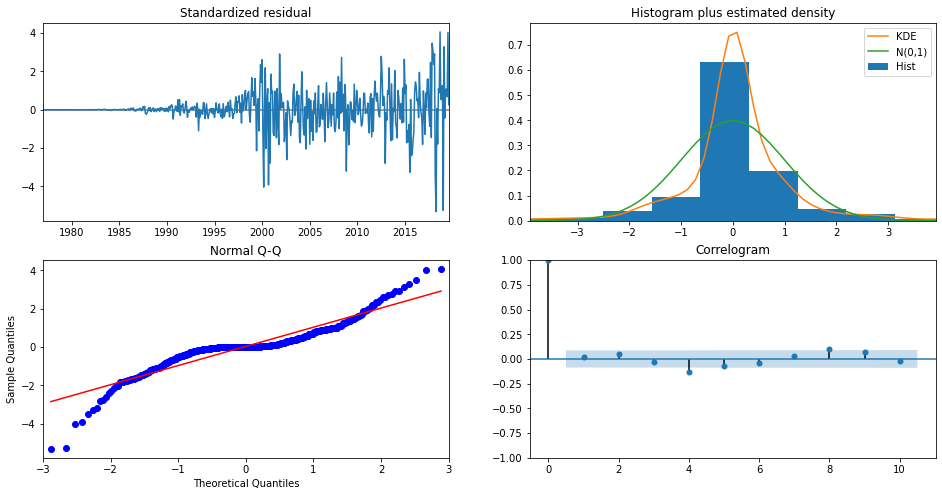

In [58]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [41]:
y[500::]

ds
2014-04-30     68.050256
2014-05-31     68.013924
2014-06-30     66.888825
2014-07-31     67.065620
2014-08-31     66.087572
                 ...    
2019-03-31     97.532491
2019-04-30    100.366358
2019-05-31    101.212901
2019-06-30    108.235000
2019-07-31    111.110000
Freq: M, Name: y, Length: 64, dtype: float64

In [58]:
pred_ci['lower y']

ds
2014-04-30     63.708789
2014-05-31     65.349924
2014-06-30     65.082944
2014-07-31     63.781181
2014-08-31     63.967929
                 ...    
2019-03-31     93.791111
2019-04-30     95.244670
2019-05-31     97.903906
2019-06-30     98.433456
2019-07-31    107.702976
Freq: M, Name: lower y, Length: 64, dtype: float64

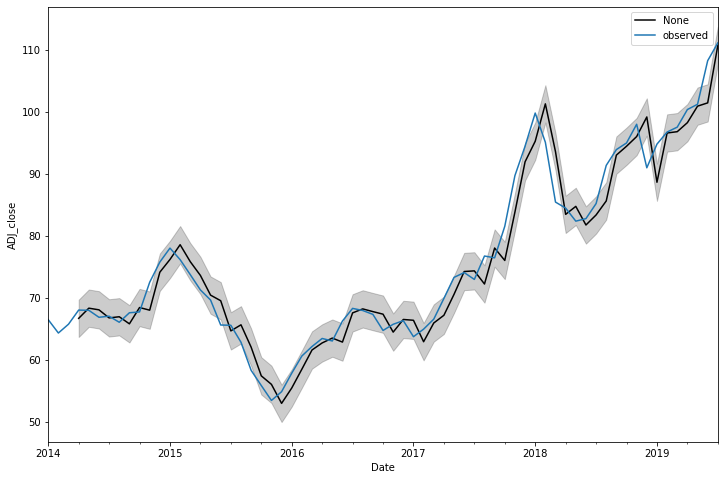

In [59]:
fig = plt.figure(figsize=(12,8))
pred = results.get_prediction(start=pd.to_datetime('2014-04-30'), dynamic=False)
pred_ci = pred.conf_int()
pred.predicted_mean.plot(color='black')
# pred_transformed=pred.predicted_mean.cumsum()
# pred_low_trans=pred_ci['lower y_diff'].cumsum()
# pred_high_trans=pred_ci['upper y_diff'].cumsum()
ax = y['2014':].plot(label='observed')

ax.fill_between(pred_ci.index,
                pred_ci['lower y'],
                pred_ci['upper y'], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('ADJ_close')
plt.legend()
plt.show()

## Use the last 7 values we have in the timeseries as ground truth

In [60]:
# ground truth
y[-7::]

ds
2019-01-31     94.792729
2019-02-28     96.738087
2019-03-31     97.532491
2019-04-30    100.366358
2019-05-31    101.212901
2019-06-30    108.235000
2019-07-31    111.110000
Freq: M, Name: y, dtype: float64

In [61]:
yhat=forecast[['ds','yhat']]

In [62]:
# set the column as the index
yhat.set_index('ds', inplace=True)

In [63]:
proph_y=yhat.resample('M').mean()

In [65]:
proph_y[-19:-12]

,yhat
ds,
2019-01-31,88.953408
2019-02-28,89.225161
2019-03-31,89.607373
2019-04-30,90.311264
2019-05-31,90.510900
2019-06-30,91.040099
2019-07-31,91.260080


In [66]:
pred.predicted_mean[-7::]

ds
2019-01-31     88.646883
2019-02-28     96.584581
2019-03-31     96.797242
2019-04-30     98.250801
2019-05-31    100.910037
2019-06-30    101.439587
2019-07-31    110.709106
Freq: M, dtype: float64

## ARIMA ERR

In [67]:
Err_df=pd.concat([y[-7::],pred.predicted_mean[-7::],proph_y[-19:-12]['yhat']],axis=1)


In [68]:
Err_df=Err_df.rename(columns={0:'arima'})

In [69]:
Err_df['ar_err']=abs(Err_df['arima']-Err_df['y'])
Err_df['pr_err']=abs(Err_df['yhat']-Err_df['y'])

In [70]:
Err_df

,y,arima,yhat,ar_err,pr_err
ds,,,,,
2019-01-31,94.792729,88.646883,88.953408,6.145845,5.839321
2019-02-28,96.738087,96.584581,89.225161,0.153507,7.512926
2019-03-31,97.532491,96.797242,89.607373,0.735250,7.925119
2019-04-30,100.366358,98.250801,90.311264,2.115557,10.055094
2019-05-31,101.212901,100.910037,90.510900,0.302864,10.702001
2019-06-30,108.235000,101.439587,91.040099,6.795413,17.194901
2019-07-31,111.110000,110.709106,91.260080,0.400894,19.849921


In [71]:
Err_df.sum()

y         709.987567
arima     693.338238
yhat      630.908283
ar_err     16.649329
pr_err     79.079284
dtype: float64